In [36]:
import pandas as pd                                       # dataframes y utilidades
from datetime import timedelta                            # diferencia entre datos tipo tiempo
from oandapyV20 import API                                # conexion con broker OANDA
import oandapyV20.endpoints.instruments as instruments    # informacion de precios historicos

In [37]:
def f_precios_masivos(p0_fini, p1_ffin, p2_gran, p3_inst, p4_oatk, p5_ginc):
    """
    Parameters
    ----------
    p0_fini
    p1_ffin
    p2_gran
    p3_inst
    p4_oatk
    p5_ginc
    Returns
    -------
    dc_precios
    Debugging
    ---------
    """

    def f_datetime_range_fx(p0_start, p1_end, p2_inc, p3_delta):
        """
        Parameters
        ----------
        p0_start
        p1_end
        p2_inc
        p3_delta
        Returns
        -------
        ls_resultado
        Debugging
        ---------
        """

        ls_result = []
        nxt = p0_start

        while nxt <= p1_end:
            ls_result.append(nxt)
            if p3_delta == 'minutes':
                nxt += timedelta(minutes=p2_inc)
            elif p3_delta == 'hours':
                nxt += timedelta(hours=p2_inc)
            elif p3_delta == 'days':
                nxt += timedelta(days=p2_inc)

        return ls_result

    # inicializar api de OANDA

    api = API(access_token=p4_oatk)

    gn = {'S30': 30, 'S10': 10, 'S5': 5, 'M1': 60, 'M5': 60 * 5, 'M15': 60 * 15,
          'M30': 60 * 30, 'H1': 60 * 60, 'H4': 60 * 60 * 4, 'H8': 60 * 60 * 8,
          'D': 60 * 60 * 24, 'W': 60 * 60 * 24 * 7, 'M': 60 * 60 * 24 * 7 * 4}

    # -- para el caso donde con 1 peticion se cubran las 2 fechas
    if int((p1_ffin - p0_fini).total_seconds() / gn[p2_gran]) < 4999:

        # Fecha inicial y fecha final
        f1 = p0_fini.strftime('%Y-%m-%dT%H:%M:%S')
        f2 = p1_ffin.strftime('%Y-%m-%dT%H:%M:%S')

        # Parametros pra la peticion de precios
        params = {"granularity": p2_gran, "price": "M", "dailyAlignment": 16, "from": f1,
                  "to": f2}

        # Ejecutar la peticion de precios
        a1_req1 = instruments.InstrumentsCandles(instrument=p3_inst, params=params)
        a1_hist = api.request(a1_req1)

        # Para debuging
        # print(f1 + ' y ' + f2)
        lista = list()

        # Acomodar las llaves
        for i in range(len(a1_hist['candles']) - 1):
            lista.append({'TimeStamp': a1_hist['candles'][i]['time'],
                          'Open': a1_hist['candles'][i]['mid']['o'],
                          'High': a1_hist['candles'][i]['mid']['h'],
                          'Low': a1_hist['candles'][i]['mid']['l'],
                          'Close': a1_hist['candles'][i]['mid']['c']})

        # Acomodar en un data frame
        r_df_final = pd.DataFrame(lista)
        r_df_final = r_df_final[['TimeStamp', 'Open', 'High', 'Low', 'Close']]
        r_df_final['TimeStamp'] = pd.to_datetime(r_df_final['TimeStamp'])
        r_df_final['Open'] = pd.to_numeric(r_df_final['Open'], errors='coerce')
        r_df_final['High'] = pd.to_numeric(r_df_final['High'], errors='coerce')
        r_df_final['Low'] = pd.to_numeric(r_df_final['Low'], errors='coerce')
        r_df_final['Close'] = pd.to_numeric(r_df_final['Close'], errors='coerce')

        return r_df_final

    # -- para el caso donde se construyen fechas secuenciales
    else:

        # hacer series de fechas e iteraciones para pedir todos los precios
        fechas = f_datetime_range_fx(p0_start=p0_fini, p1_end=p1_ffin, p2_inc=p5_ginc,
                                     p3_delta='minutes')

        # Lista para ir guardando los data frames
        lista_df = list()

        for n_fecha in range(0, len(fechas) - 1):

            # Fecha inicial y fecha final
            f1 = fechas[n_fecha].strftime('%Y-%m-%dT%H:%M:%S')
            f2 = fechas[n_fecha + 1].strftime('%Y-%m-%dT%H:%M:%S')

            # Parametros pra la peticion de precios
            params = {"granularity": p2_gran, "price": "M", "dailyAlignment": 16, "from": f1,
                      "to": f2}

            # Ejecutar la peticion de precios
            a1_req1 = instruments.InstrumentsCandles(instrument=p3_inst, params=params)
            a1_hist = api.request(a1_req1)

            # Para debuging
            print(f1 + ' y ' + f2)
            lista = list()

            # Acomodar las llaves
            for i in range(len(a1_hist['candles']) - 1):
                lista.append({'TimeStamp': a1_hist['candles'][i]['time'],
                              'Open': a1_hist['candles'][i]['mid']['o'],
                              'High': a1_hist['candles'][i]['mid']['h'],
                              'Low': a1_hist['candles'][i]['mid']['l'],
                              'Close': a1_hist['candles'][i]['mid']['c']})

            # Acomodar en un data frame
            pd_hist = pd.DataFrame(lista)
            pd_hist = pd_hist[['TimeStamp', 'Open', 'High', 'Low', 'Close']]
            pd_hist['TimeStamp'] = pd.to_datetime(pd_hist['TimeStamp'])

            # Ir guardando resultados en una lista
            lista_df.append(pd_hist)

        # Concatenar todas las listas
        r_df_final = pd.concat([lista_df[i] for i in range(0, len(lista_df))])

        # resetear index en dataframe resultante porque guarda los indices del dataframe pasado
        r_df_final = r_df_final.reset_index(drop=True)
        r_df_final['Open'] = pd.to_numeric(r_df_final['Open'], errors='coerce')
        r_df_final['High'] = pd.to_numeric(r_df_final['High'], errors='coerce')
        r_df_final['Low'] = pd.to_numeric(r_df_final['Low'], errors='coerce')
        r_df_final['Close'] = pd.to_numeric(r_df_final['Close'], errors='coerce')

        return r_df_final


In [62]:
OA_Ak = 'bfbf69aa713879edeb04a94b58026443-6e6812cb8a409c06bf5bdeddbf17fb78'

-Las funciones previas son para descargar los datos de forex

In [63]:
# token de OANDA

OA_In = "EUR_USD"                  # Instrumento
OA_Gn = "D"                        # Granularidad de velas
fini = pd.to_datetime("2019-02-01 00:00:00").tz_localize('GMT')  # Fecha inicial
ffin = pd.to_datetime("2020-02-01 00:00:00").tz_localize('GMT')  # Fecha final

# Descargar precios masivos
data = f_precios_masivos(p0_fini=fini, p1_ffin=ffin, p2_gran=OA_Gn,
                             p3_inst=OA_In, p4_oatk=OA_Ak, p5_ginc=4900)
data=pd.DataFrame(data)

-Aqui eliges la divisa de la que deseas obtener los precios, aqui yo elegi EURO-USD.

In [ ]:
n=10
def BBANDS(data,window= n):
    MA = data.Close.rolling(window=n).mean()
    SD = data.Close.rolling(window=n).std()
    data['UpperBB'] = MA + (2 * SD) 
    data['LowerBB'] = MA - (2 * SD)
    return data

-En la definicion de esta funcio creo la banda superior e inferior multiplicando por 2 veces su desviacion, asi se crean los limites de las bandas bollinger. 

In [64]:

NIFTY_BBANDS = BBANDS(data, n)
print(NIFTY_BBANDS)

                    TimeStamp     Open     High      Low    Close   UpperBB  \
0   2019-01-31 21:00:00+00:00  1.14454  1.14884  1.14345  1.14598       NaN   
1   2019-02-01 21:00:00+00:00  1.14594  1.14616  1.14530  1.14562       NaN   
2   2019-02-03 21:00:00+00:00  1.14521  1.14603  1.14244  1.14344       NaN   
3   2019-02-04 21:00:00+00:00  1.14347  1.14404  1.14011  1.14128       NaN   
4   2019-02-05 21:00:00+00:00  1.14130  1.14138  1.13622  1.13684       NaN   
5   2019-02-06 21:00:00+00:00  1.13682  1.13689  1.13247  1.13425       NaN   
6   2019-02-07 21:00:00+00:00  1.13428  1.13509  1.13212  1.13222       NaN   
7   2019-02-08 21:00:00+00:00  1.13225  1.13250  1.13224  1.13224       NaN   
8   2019-02-10 21:00:00+00:00  1.13202  1.13300  1.12674  1.12764       NaN   
9   2019-02-11 21:00:00+00:00  1.12768  1.13397  1.12578  1.13317  1.150081   
10  2019-02-12 21:00:00+00:00  1.13320  1.13415  1.12643  1.12665  1.148139   
11  2019-02-13 21:00:00+00:00  1.12663  1.13097  1.1

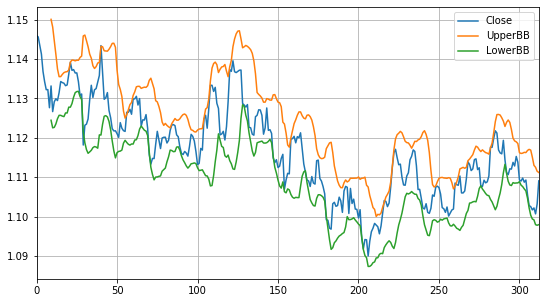

In [65]:

pd.concat([NIFTY_BBANDS.Close,NIFTY_BBANDS.UpperBB,NIFTY_BBANDS.LowerBB],axis=1).plot(figsize=(9,5),grid=True)

-La estrategia que yo hago con bandas bollinger es verificar que pasen estos limites, por ejemplo si paso la banda superior significa que la divisa ira a la baja, si pasa la banda inferior singnifica que ira a la alza. 